In [1]:
import yaml
import sys
sys.path.append("../../src")
from images import create_train_test
from images import to_tensorflow
from images import augment_image
from images import learning_curves
from images import create_model
from keras.utils import plot_model
import os
import tensorflow as tf

## Geotags soft f1

In [2]:
with open("../../ml_models/images/image_model.yaml", "r") as f:
    image_model_config = yaml.safe_load(f)

INPUT_SHAPE = (224,224,3)

data_path = "../../data/processed/data.json"
#This splits the recepies into train and test. This doesn't actually load the features of the data
X_train, X_val, y_train, y_val = create_train_test(image_model_config,data_path, "geographical_tags_updated")

#This part loads in the data as tensorflow objects
train_ds, val_ds, N_LABELS, y_val_bin, mlb = to_tensorflow(X_train, X_val, y_train, y_val, image_model_config)

2023-12-06 14:39:29.622210: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-06 14:39:29.622238: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-06 14:39:29.622244: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-06 14:39:29.622488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 14:39:29.622515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Apply data augmentation to the training dataset
train_ds_augmented = train_ds.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Unbatch the augmented dataset
train_ds = train_ds_augmented.unbatch()

# Apply data augmentation to the training dataset
val_ds_augmented = val_ds.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Unbatch the augmented dataset
val_ds = val_ds_augmented.unbatch()

model_path = f"../ml_models/images/"
number = str(len(os.listdir(model_path)))
model_path += f"final_model_{image_model_config["EPOCHS"]}_epochs"+ ".h5"

In [4]:
model = create_model(image_model_config, INPUT_SHAPE, N_LABELS)

In [5]:
#plot_model(model, show_shapes=True)

In [6]:
history = model.fit(train_ds,
                    epochs=int(image_model_config["EPOCHS"]),
                    validation_data=val_ds)

Epoch 1/25


2023-12-06 14:39:37.510723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


320/320 [==============================] - 98s 234ms/step - loss: 0.9233 - macro_f1: 0.0775 - val_loss: 0.9237 - val_macro_f1: 0.0681
Epoch 2/25
320/320 [==============================] - 69s 215ms/step - loss: 0.9226 - macro_f1: 0.0781 - val_loss: 0.9211 - val_macro_f1: 0.0737
Epoch 3/25
320/320 [==============================] - 69s 215ms/step - loss: 0.9222 - macro_f1: 0.0780 - val_loss: 0.9198 - val_macro_f1: 0.0774
Epoch 4/25
320/320 [==============================] - 70s 218ms/step - loss: 0.9228 - macro_f1: 0.0773 - val_loss: 0.9208 - val_macro_f1: 0.0772
Epoch 5/25
320/320 [==============================] - 71s 221ms/step - loss: 0.9221 - macro_f1: 0.0782 - val_loss: 0.9217 - val_macro_f1: 0.0770
Epoch 6/25
320/320 [==============================] - 70s 216ms/step - loss: 0.9229 - macro_f1: 0.0775 - val_loss: 0.9214 - val_macro_f1: 0.0770
Epoch 7/25
320/320 [==============================] - 70s 216ms/step - loss: 0.9230 - macro_f1: 0.0778 - val_loss: 0.9198 - val_macro_f1: 0.0

In [7]:
model.save_weights(model_path)

In [41]:
from matplotlib import pyplot as plt
import matplotlib.style as style
rc = {'axes.facecolor':'white',
      'axes.grid' : False,
      'axes.spines.bottom': False,
      'axes.spines.left': False,
      'axes.spines.right': False,
      'axes.spines.top': False,
      'savefig.transparent': False}

def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    plt.rcParams.update(rc)

    plt.figure(figsize=(18, 5))  # Increase the figure height

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel("Epochs")
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.xlabel("Epochs")
    plt.title('Training and Validation Macro F1-score')

    #plt.subplots_adjust(hspace=0.2)  # Adjust the vertical space between subplots
    plt.savefig("../../visualizations/training_analysis.png", dpi = 300, bbox_inches = "tight")
    plt.show()

    
    return loss, val_loss, macro_f1, val_macro_f1


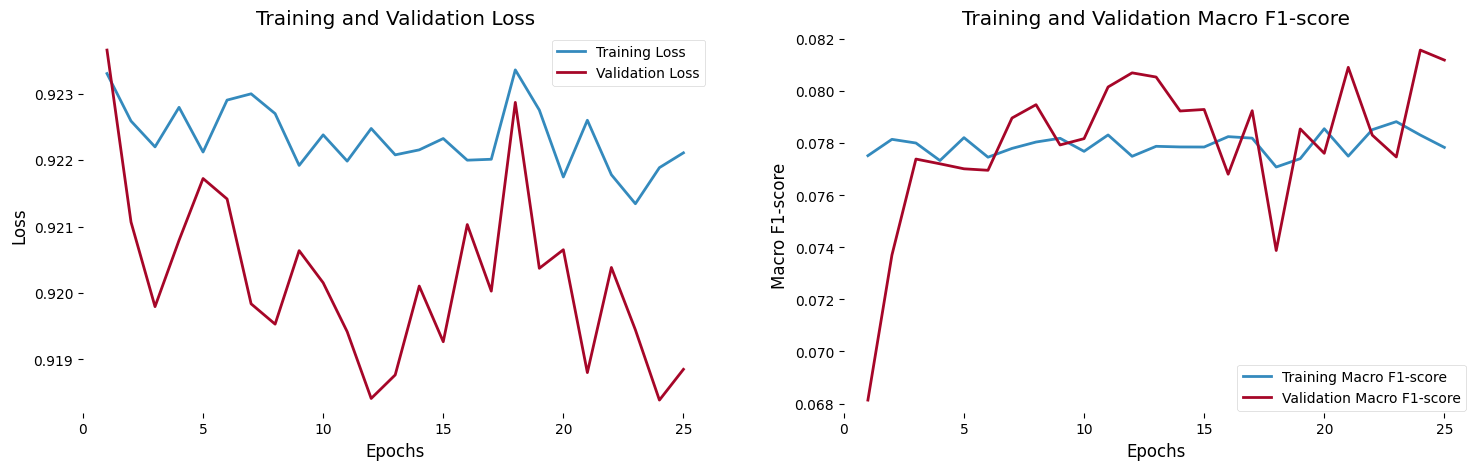

In [42]:
model_bce_losses, model_bce_val_losses, model_bce_macro_f1s, model_bce_val_macro_f1s = learning_curves(history)